# TCN Model on Lab p4679
Author: Camilla Billari <br> 
Date: 07/02/24

Fitting a TCN to the lab p4679 dataset.

In [1]:
# Import relevant libraries
import matplotlib.pyplot as plt

from scripts.models.tcn_oneshot_multistep import MultiStepTCN
from utils.data_preprocessing import (
    compare_feature_statistics,
    create_dataset,
    moving_average_causal_filter,
    normalise_dataset,
    split_train_test_forecast_windows,
)

# Import local modules - note: dependent on above path being set.
from utils.dataset import SlowEarthquakeDataset

# from utils.nn_io import load_model, save_model
from utils.general_functions import set_seed, set_torch_device
from utils.nn_train import eval_model_on_test_set, train_model
from utils.plotting import (
    plot_all_data_results,
    plot_example_sample,
    plot_metric_results,
    plot_original_vs_processed_data,
    plot_single_seg_result,
)

In [2]:
# Set random seed
SEED = 17  # random seed for the dataset and model
set_seed(SEED)

# Set torch device
device = set_torch_device()

GPU name: NVIDIA A100-SXM4-40GB
Max GPU memory: 42.297786368 GiB


## Load Data

In [3]:
EXP = "p4679"  # select Marone p4679 experiment

# Load dataset and convert to dataframe
dataset = SlowEarthquakeDataset([EXP])
df = SlowEarthquakeDataset.convert_to_df(dataset, EXP)

df.head()

,obs_shear_stress,obs_normal_stress,obs_ecdisp,time
0,5.091520,6.986740,22107.1104,0.000
1,5.090652,6.988410,22109.7823,0.001
2,5.089989,6.986299,22103.7900,0.002
3,5.089492,6.985970,22109.2161,0.003
4,5.088243,6.987547,22108.5900,0.004


In [4]:
# Select segment average and scale down by 10^8
shear_stress_df = df["obs_shear_stress"]

shear_stress_df.shape

(301721,)

## Data Pre-processing

### Denoising

In [5]:
# Data smoothing
SMOOTHING_WINDOW = 13  # moving average window size
DOWNSAMPLING_FACTOR = 13

# Smooth the data
df_smoothed = moving_average_causal_filter(
    shear_stress_df, SMOOTHING_WINDOW, DOWNSAMPLING_FACTOR
)

df_smoothed.shape

(23209,)

In [6]:
# Check if smoothed results are statistically significantly different
results = compare_feature_statistics(shear_stress_df, df_smoothed)
print(results)

{'mean_comparison': {'t_statistic': -0.00016938842232550443, 'p_value': 0.9998648476976804, 'significant': False}, 'variance_comparison': {'f_statistic': 2.8692438122653928e-08, 'p_value': 0.9998648792730243, 'significant': False}}


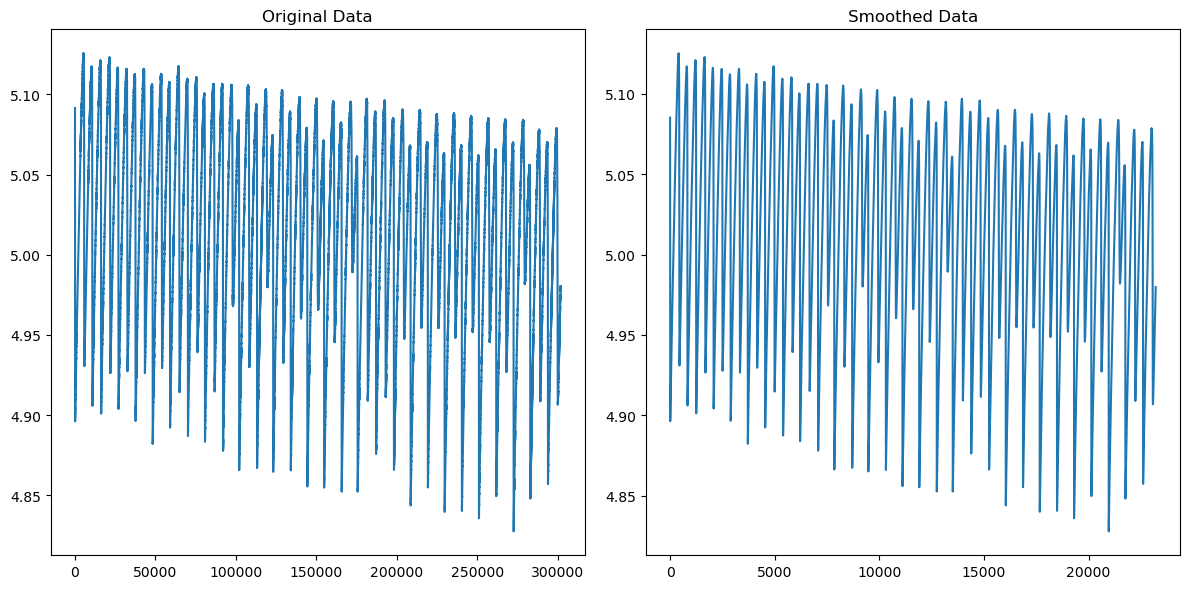

In [7]:
plot_original_vs_processed_data(shear_stress_df, df_smoothed, "line")

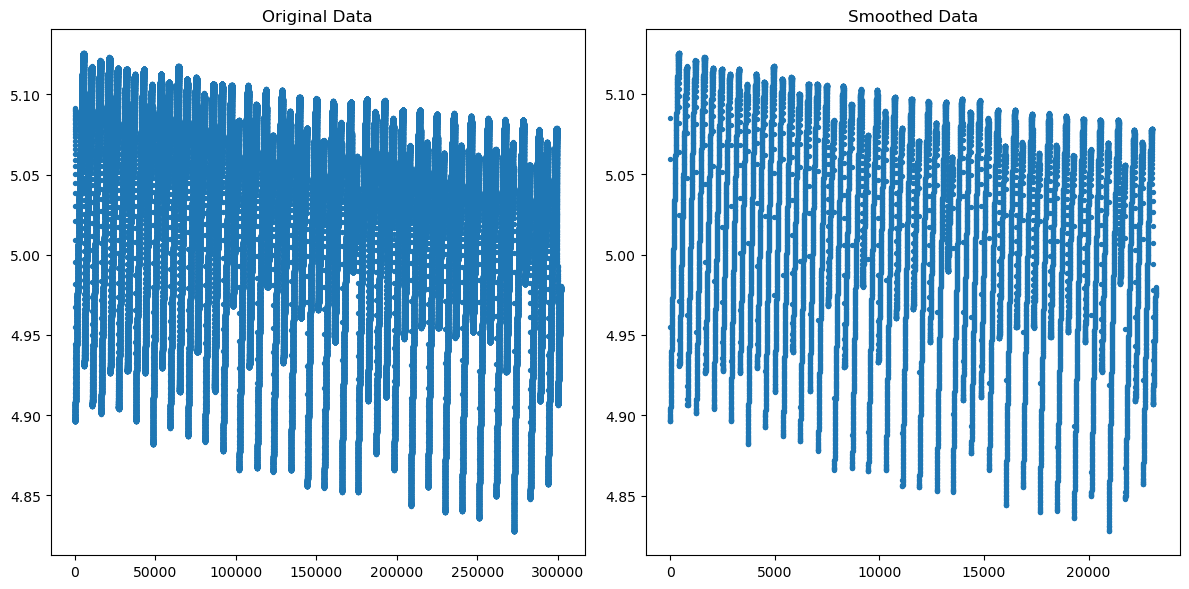

In [8]:
plot_original_vs_processed_data(shear_stress_df, df_smoothed, "scatter")

## Creating the datastet

In [9]:
# Dataset parameters
LOOKBACK, FORECAST = 180, 30  # lookback and forecast values
N_FORECAST_WINDOWS = 180  # n forecasted windows in test set
N_VALIDATION_WINDOWS = 180  # n forecasted windows in validation set

# Pre-process the data into windows
X, y = create_dataset(df_smoothed, LOOKBACK, FORECAST)

print(f"X and y shapes: {X.shape}, {y.shape}")

X and y shapes: torch.Size([23000, 180]), torch.Size([23000, 30])


In [10]:
# Split into train and test sets and normalise it
(
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
) = split_train_test_forecast_windows(
    X, y, FORECAST, N_FORECAST_WINDOWS, N_VALIDATION_WINDOWS
)

# Display shapes of the created datasets
print(f"Training data shapes: {X_train.shape}, {y_train.shape}")
print(f"Testing data shapes: {X_test.shape}, {y_test.shape}")
print(f"Validation data shapes: {X_val.shape}, {y_val.shape}")

Training data shapes: torch.Size([12180, 180]), torch.Size([12180, 30])
Testing data shapes: torch.Size([5400, 180]), torch.Size([5400, 30])
Validation data shapes: torch.Size([5400, 180]), torch.Size([5400, 30])


### Normalising with scaler based on the training set

In [11]:
# Normalise the dataset and save all sets into data_dict; keep scalers for later.
data_dict, scaler_X, scaler_y = normalise_dataset(
    X_train, y_train, X_test, y_test, X_val, y_val
)

print(data_dict.keys())

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_train_sc', 'y_train_sc', 'X_test_sc', 'y_test_sc', 'X_val', 'y_val', 'X_val_sc', 'y_val_sc'])


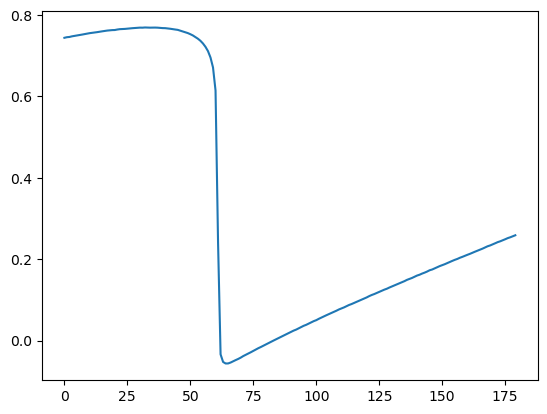

In [12]:
# Plot 3rd X_test window
plt.plot(data_dict["X_test_sc"][2, :])

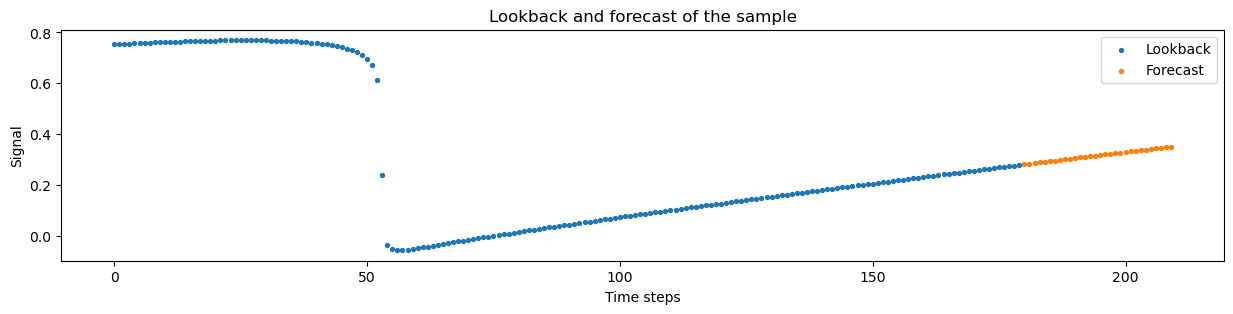

In [13]:
plot_example_sample(
    data_dict["X_test_sc"], data_dict["y_test_sc"], 10, LOOKBACK, FORECAST
)

## Modelling

In [14]:
# For TCN config
N_VARIATES = 1
HIDDEN_SIZE = 50
KERNEL_SIZE = 3
OUTPUT_SIZE = FORECAST
DROPOUT = 0

model = MultiStepTCN(
    N_VARIATES, LOOKBACK, OUTPUT_SIZE, [HIDDEN_SIZE], KERNEL_SIZE, DROPOUT
).to(device)

### Training

In [15]:
# For TCN training
N_EPOCHS = 75
results_dict = train_model(model, N_EPOCHS, data_dict, scaler_y, device)

Training model on cuda


Epoch [75/75], Train RMSE: 0.0133, Val RMSE: 0.0199: 100%|██████████| 75/75 [02:01<00:00,  1.63s/it]


In [16]:
results_dict = eval_model_on_test_set(
    model, results_dict, data_dict, scaler_y, device
)

## Results

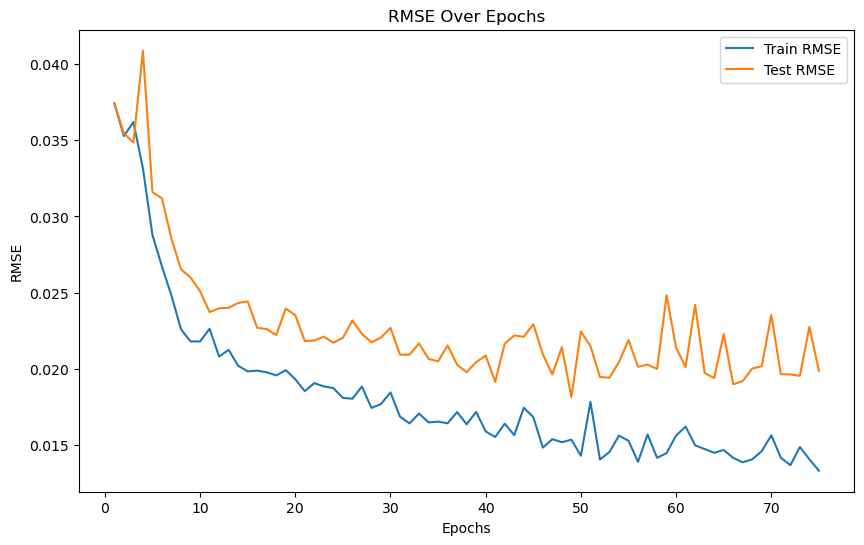

In [17]:
# Plot RMSE
plot_metric_results(
    N_EPOCHS,
    results_dict["train_rmse_list"],
    results_dict["val_rmse_list"],
    "RMSE",
)

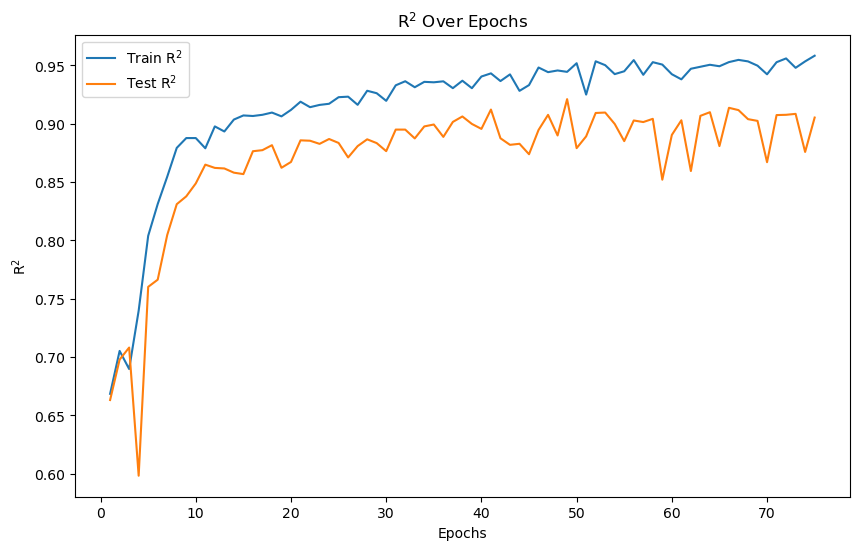

In [18]:
# Plot R2
plot_metric_results(
    N_EPOCHS,
    results_dict["train_r2_list"],
    results_dict["val_r2_list"],
    "R$^2$",
)

In [19]:
# Plot predictions against true values
TITLE = "Original Time Series and Model Predictions of Segment 1 sum"
X_LABEL = "Samples"
Y_LABEL = "Shear Stress (MPa)"
ZOOM_MIN = 1100
ZOOM_MAX = 1250
ZOOM_WINDOW = [ZOOM_MIN, ZOOM_MAX]

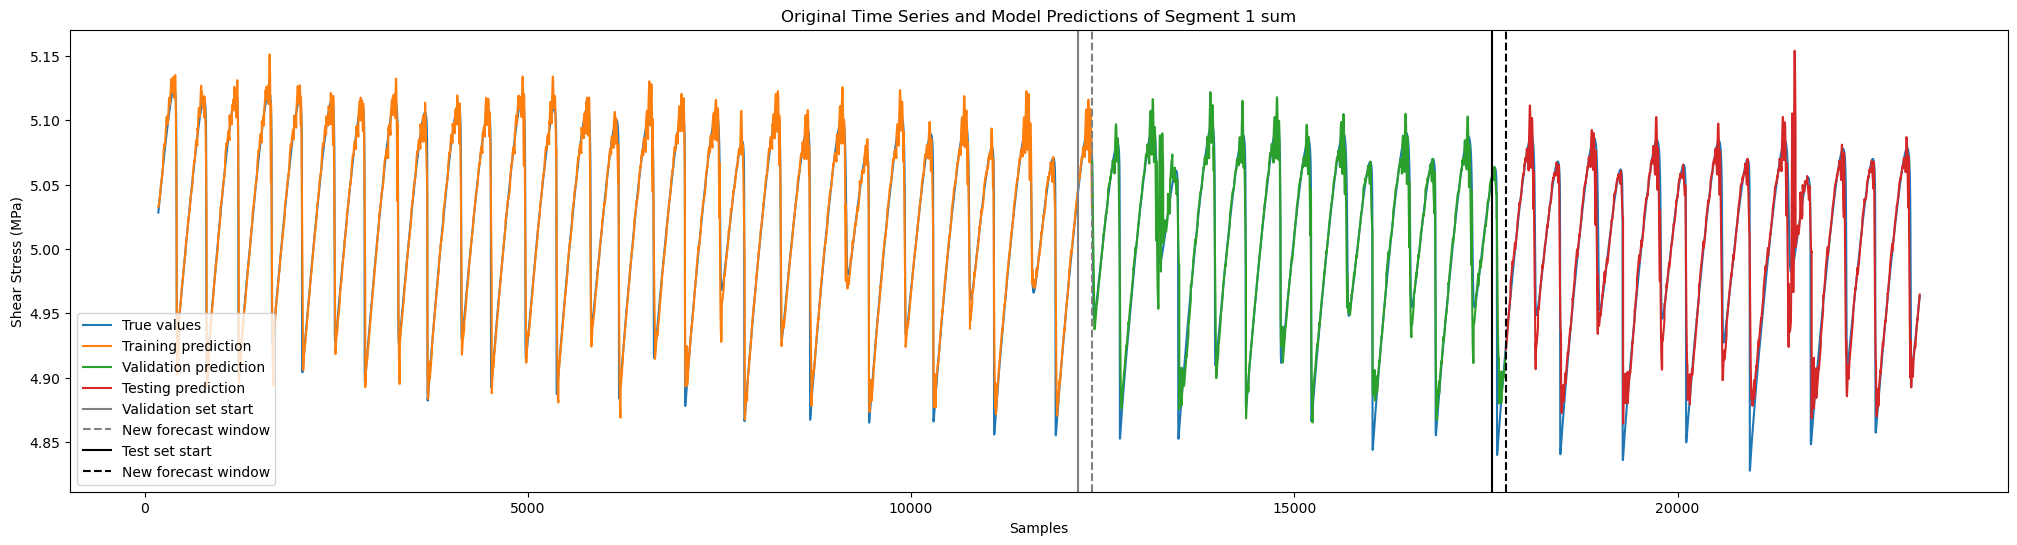

In [20]:
plot_all_data_results(
    data_dict, results_dict, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, []
)
# TODO: CHANGE HORRIBLE COLOURS

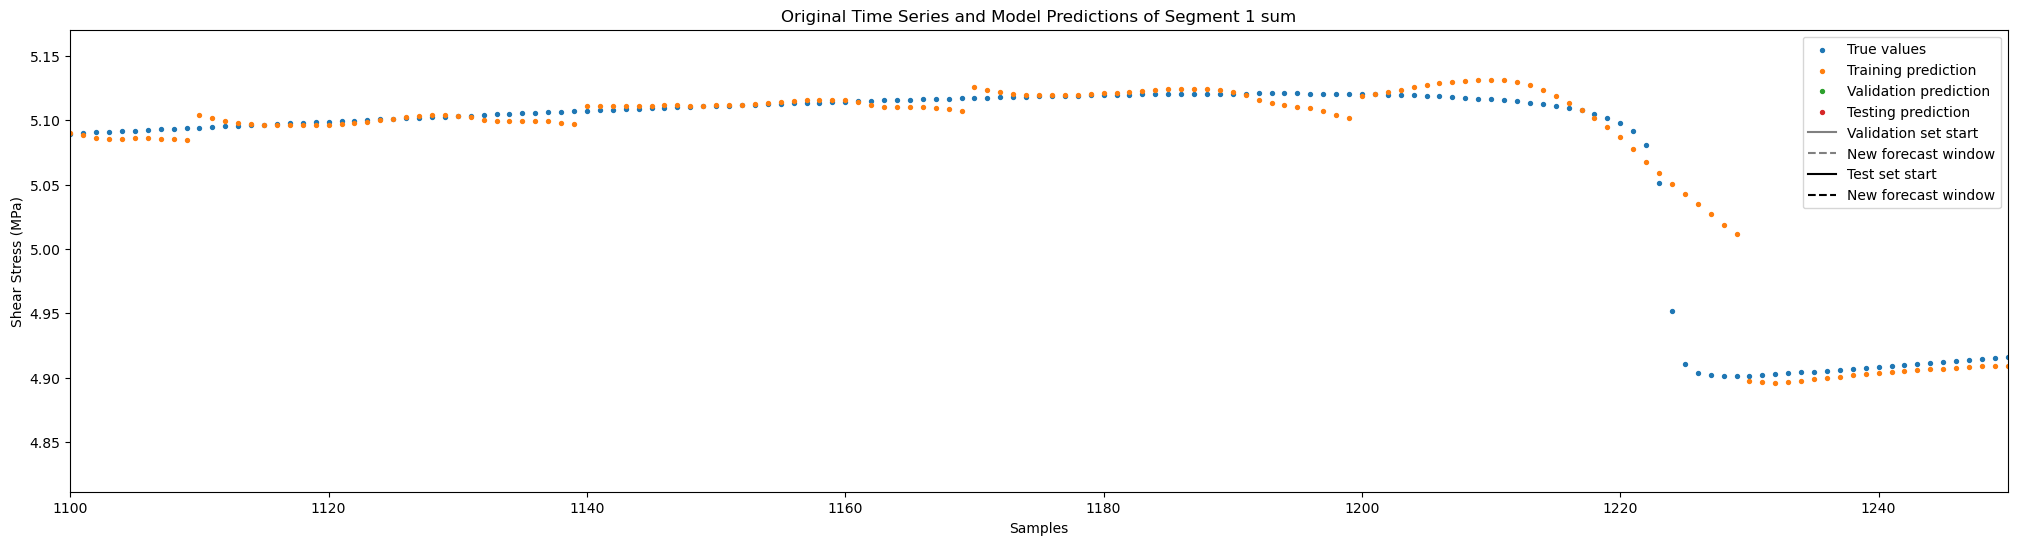

In [21]:
plot_all_data_results(
    data_dict,
    results_dict,
    LOOKBACK,
    FORECAST,
    TITLE,
    X_LABEL,
    Y_LABEL,
    ZOOM_WINDOW,
    plot_type="scatter",
)
# LOOK AT BOKE

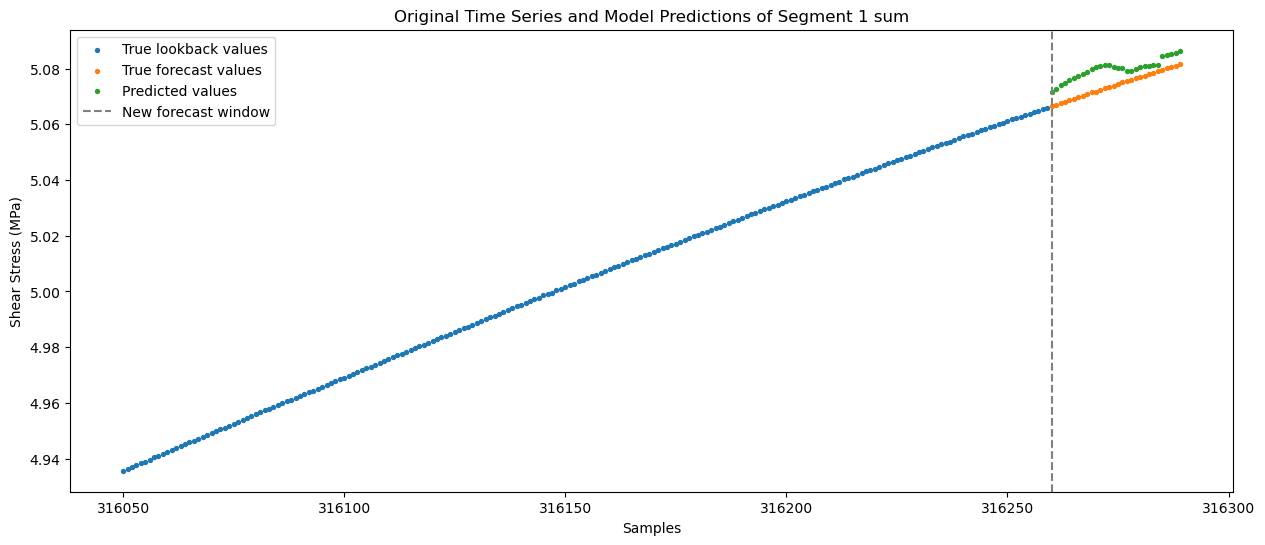

In [22]:
plot_single_seg_result(
    data_dict,
    results_dict,
    LOOKBACK,
    FORECAST,
    1505,
    TITLE,
    X_LABEL,
    Y_LABEL,
    save_plot=False,
)

In [23]:
import numpy as np
import torch
import torch.nn as nn

y_test_true = data_dict["y_test"]
y_test_pred = results_dict["y_test_pred"]

array_loss_fn = nn.MSELoss(reduction="none")

# with torch.no_grad():
loss = array_loss_fn(y_test_pred, y_test_true)

rmse = np.sqrt(loss)
avg_test_rmse = np.sqrt(torch.mean(loss, dim=1))
test_rmse_first = np.sqrt(loss[:, 0])
test_rmse_last = np.sqrt(loss[:, -1])

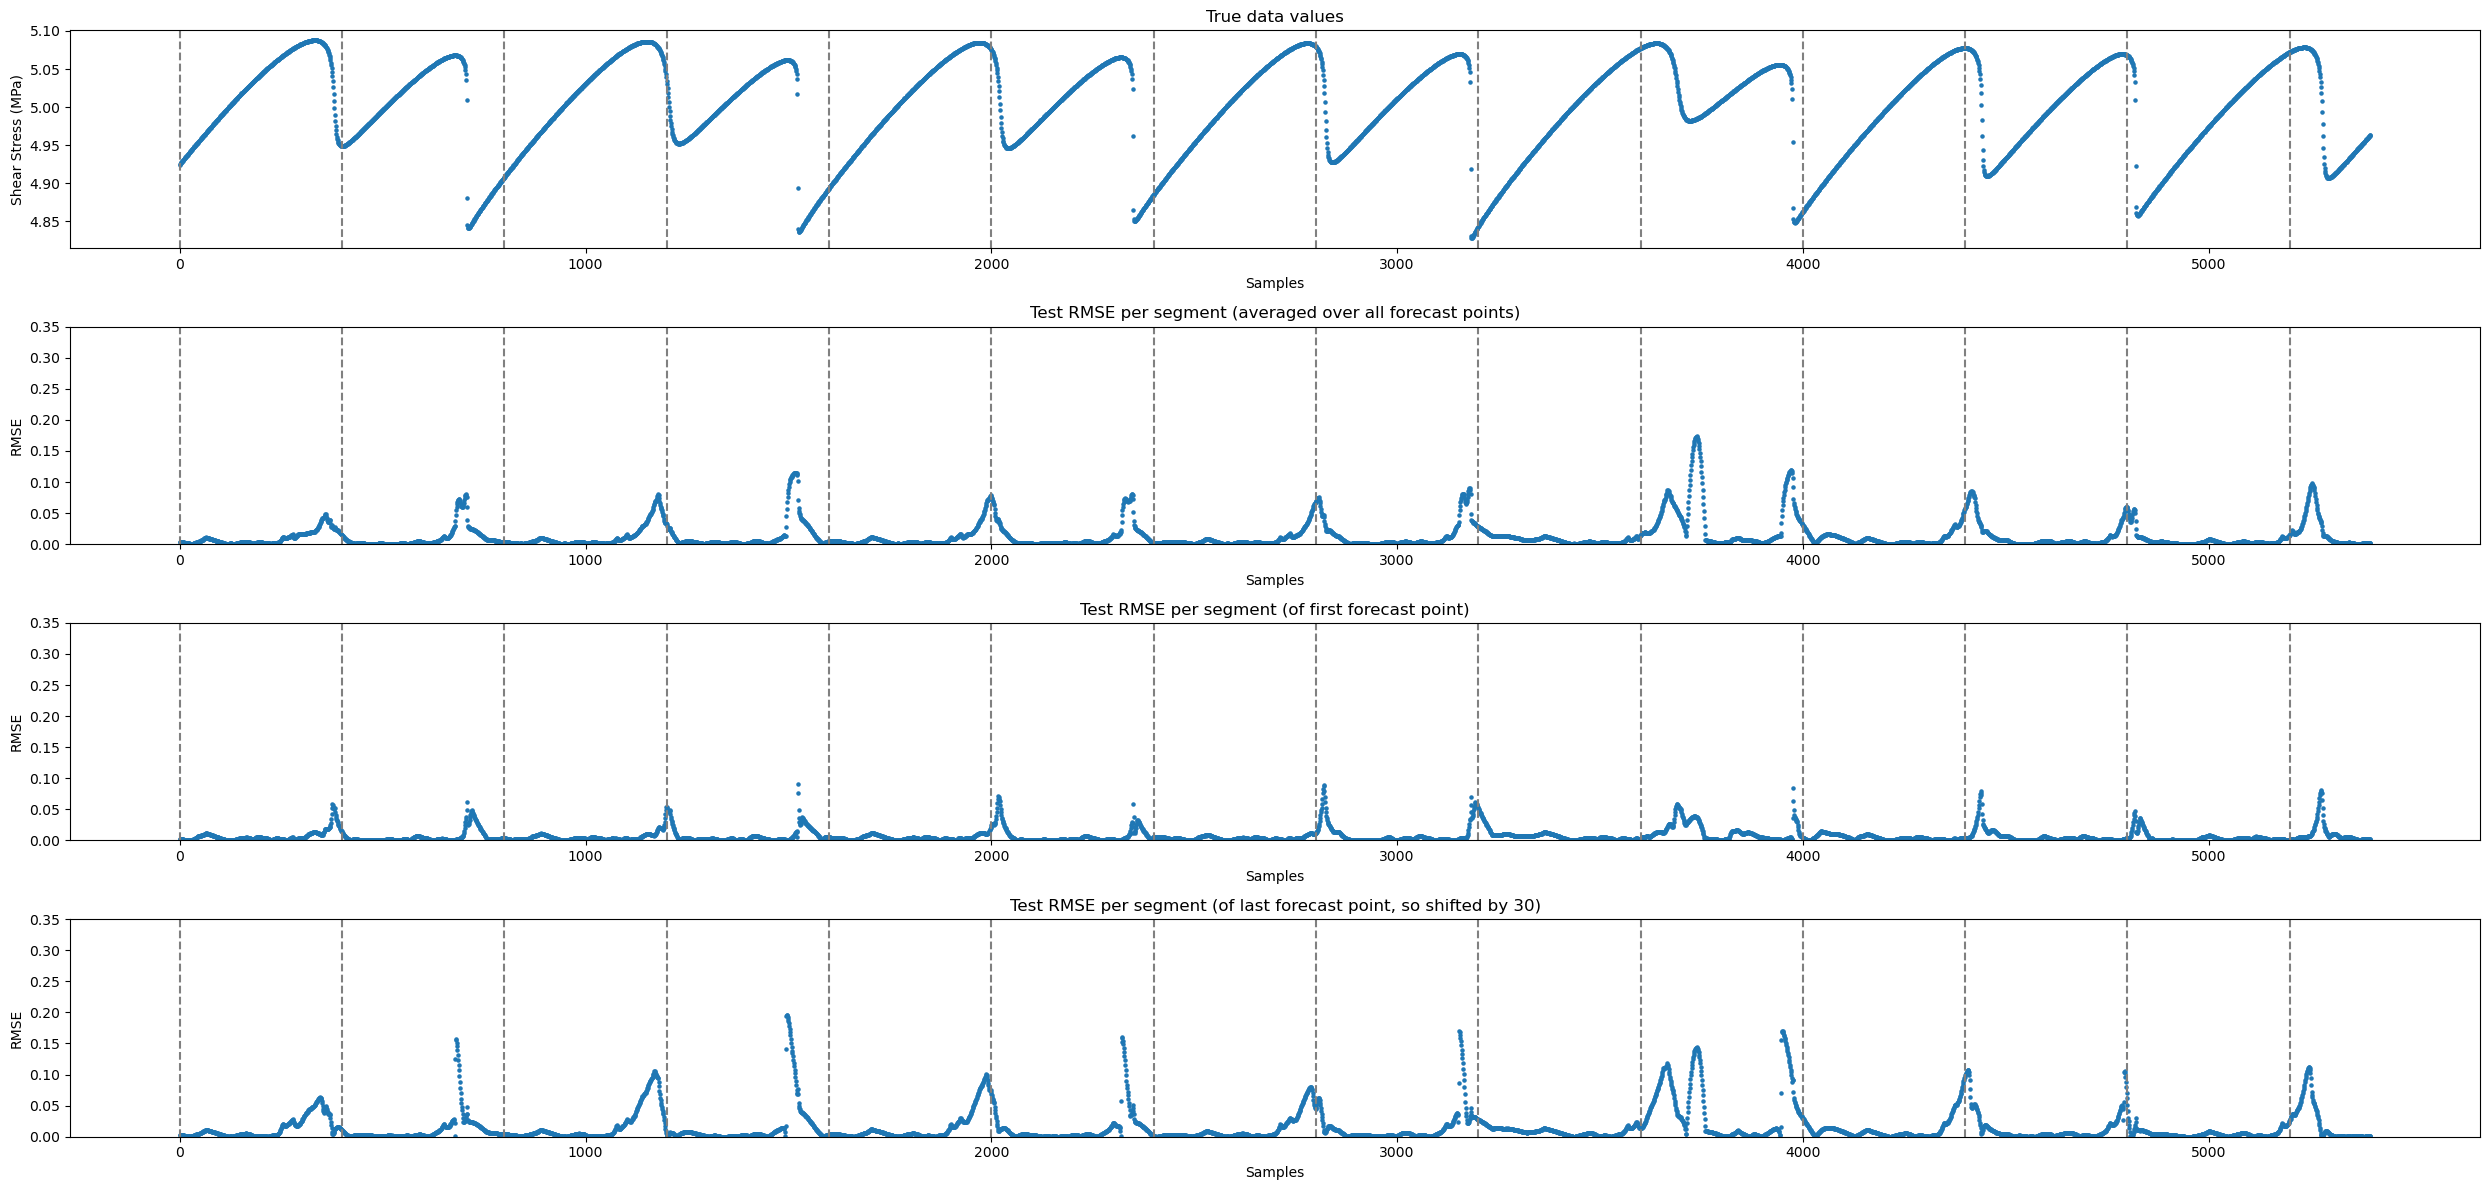

In [38]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(4, 1, figsize=(25, 12))
n_samples = len(data_dict["y_test"])

# First subplot
for x in np.arange(0, n_samples, 400):
    axs[0].axvline(
        x=x, color="grey", linestyle="--"
    )  # Add vertical lines to first subplot
    axs[1].axvline(
        x=x, color="grey", linestyle="--"
    )  # Add vertical lines to second subplot
    axs[2].axvline(
        x=x, color="grey", linestyle="--"
    )  # Add vertical lines to second subplot
    axs[3].axvline(
        x=x, color="grey", linestyle="--"
    )  # Add vertical lines to second subplot

axs[0].scatter(
    range(len(data_dict["y_test"][:, 0])), data_dict["y_test"][:, 0], s=5
)
axs[0].set_title("True data values")  # Add a title
axs[0].set_xlabel(X_LABEL)  # Set X-axis label
axs[0].set_ylabel(Y_LABEL)  # Set Y-axis label

rmse_ymax = 0.35

# Second subplot
axs[1].scatter(range(len(avg_test_rmse)), avg_test_rmse, s=5)
axs[1].set_title(
    "Test RMSE per segment (averaged over all forecast points)"
)  # Add a title
axs[1].set_xlabel(X_LABEL)  # Set X-axis label
axs[1].set_ylabel("RMSE")  # Set Y-axis label
axs[1].set_ylim([0, rmse_ymax])  # Set y-axis range from 0 to 1

# Second subplot
axs[2].scatter(range(len(test_rmse_first)), test_rmse_first, s=5)
axs[2].set_title(
    "Test RMSE per segment (of first forecast point)"
)  # Add a title
axs[2].set_xlabel(X_LABEL)  # Set X-axis label
axs[2].set_ylabel("RMSE")  # Set Y-axis label
axs[2].set_ylim([0, rmse_ymax])  # Set y-axis range from 0 to 1

# Second subplot
axs[3].scatter(range(len(test_rmse_last)), test_rmse_last, s=5)
axs[3].set_title(
    f"Test RMSE per segment (of last forecast point, so shifted by {FORECAST})"
)  # Add a title
axs[3].set_xlabel(X_LABEL)  # Set X-axis label
axs[3].set_ylabel("RMSE")  # Set Y-axis label
axs[3].set_ylim([0, rmse_ymax])  # Set y-axis range from 0 to 1

plt.tight_layout()  # Adjust the layout to not overlap
plt.show()

In [31]:
import numpy as np
import torch
import torch.nn as nn

y_test_true = data_dict["y_test"]
y_test_pred = results_dict["y_test_pred"]

array_loss_fn = nn.MSELoss(reduction="none")

with torch.no_grad():
    loss = array_loss_fn(y_test_pred, y_test_true)

    avg_test_rmse = np.sqrt(torch.mean(loss, dim=1))
    test_rmse_first = np.sqrt(loss[:, 0])
    test_rmse_last = np.sqrt(loss[:, -1])

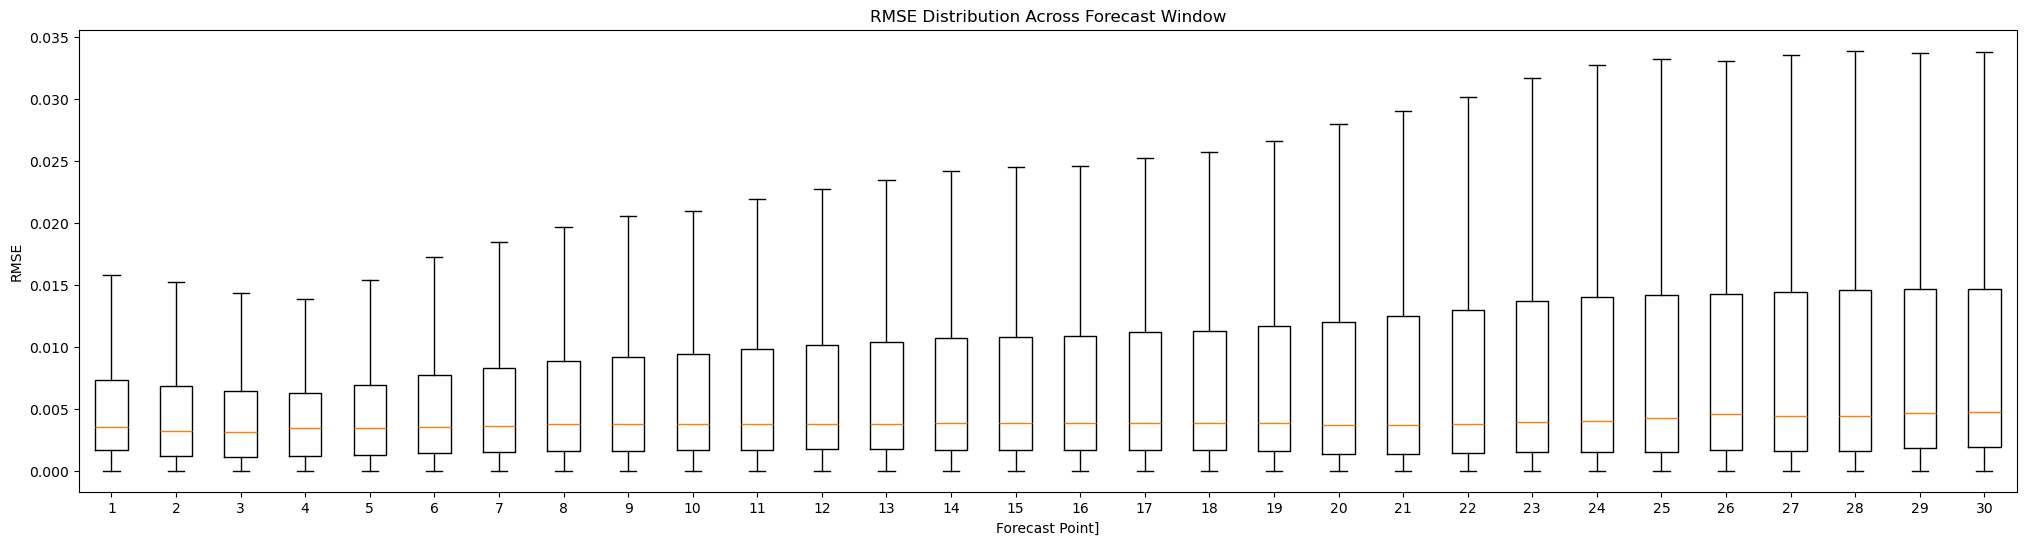

In [34]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(25, 6))
plt.boxplot(rmse.numpy(), showfliers=False)
ax.set_title("RMSE Distribution Across Forecast Window")
ax.set_xlabel("Forecast Point]")
ax.set_ylabel("RMSE")
ax.set_xticklabels([i + 1 for i in range(rmse.shape[1])])  # Label each boxplot
plt.show()